<a href="https://colab.research.google.com/github/Ayman-Abdeen/chatboot-/blob/main/chatbot/BiLSTM%2BAttention/model_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [106]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
!pip install --user -U nltk
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stops = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
from keras import backend as K
from keras.layers import Layer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import itertools

'''
This configuration file provides a series of predefined functions
'''


# ------------------custom function------------------ #

def text_to_word_list(text):  # 文本分词
    text = str(text)
    text = text.lower()
    # Text cleaning rules for English text
    import re
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()

    return text

def make_w2v_embeddings(flag, word2vec, df, embedding_dim):  # 将词转化为词向量
    vocabs = {}  # 词序号
    vocabs_count = 0  # 词个数计数器

    vocabs_not_w2v = {}  # 无法用词向量表示的词
    vocabs_not_w2v_count = 0  # Word count that cannot be represented by word vectors

    # 停用词
    # stops = set(open('data/stopwords.txt').read().strip().split('\n'))

    for index, row in df.iterrows():
        # 打印处理进度
        if index != 0 and index % 1000 == 0:
            print(str(index) + " sentences embedded.")

        for question in ['question1', 'question2']:
            q2n = []  # q2n -> question to numbers representation
            words = text_to_word_list(row[question])

            for word in words:
                # if word in stops:  # remove stop words
                # continue
                # The word of OOV is put into a dictionary that cannot be represented by a word vector, and the value is 1
                if word not in word2vec and word not in vocabs_not_w2v:  
                    vocabs_not_w2v_count += 1
                    vocabs_not_w2v[word] = 1   
                if word not in vocabs:  # Non-OOV words, extract the corresponding id
                    vocabs_count += 1
                    vocabs[word] = vocabs_count
                    q2n.append(vocabs_count)
                else:
                    q2n.append(vocabs[word])
            df.at[index, question + '_n'] = q2n

    embeddings = 1 * np.random.randn(len(vocabs) + 1, embedding_dim)  # 随机初始化一个形状为[全部词个数，词向量维度]的矩阵
    '''
    词1 [a1, a2, a3, ..., a60]
    词2 [b1, b2, b3, ..., b60]
    词3 [c1, c2, c3, ..., c60]
    '''
    embeddings[0] = 0  # 第一行用0填充，因为不存在index为0的词

    for index in vocabs:
        vocab_word = vocabs[index]
        if vocab_word in word2vec:
            embeddings[index] = word2vec[vocab_word]
    del word2vec

    return df, embeddings


def split_and_zero_padding(df, max_seq_length):  # 调整tokens长度

    # 训练集矩阵转换成字典
    X = {'left': df['question1_n'], 'right': df['question2_n']}

    # 调整到规定长度
    for dataset, side in itertools.product([X], ['left', 'right']):
        dataset[side] = pad_sequences(dataset[side], padding='pre', truncating='post', maxlen=max_seq_length)

    return dataset


class ManDist(Layer):  # 封装成keras层的曼哈顿距离计算

    # 初始化ManDist层，此时不需要任何参数输入
    def __init__(self, **kwargs):
        self.result = None
        super(ManDist, self).__init__(**kwargs)

    # Automatically build ManDist layer
    def build(self, input_shape):
        super(ManDist, self).build(input_shape)

    # Calculate Manhattan distance
    def call(self, x, **kwargs):
        self.result = K.exp(-K.sum(K.abs(x[0] - x[1]), axis=1, keepdims=True))
        return self.result

    # return result
    def compute_output_shape(self, input_shape):
        return K.int_shape(self.result)

In [19]:
# Basic package
from time import time
import pandas as pd
from sklearn.model_selection import train_test_split
import keras
from gensim.models import KeyedVectors
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Dense, Flatten, Activation, RepeatVector, Permute, Lambda, \
    Bidirectional, TimeDistributed, Dropout, Conv1D, GlobalMaxPool1D
from keras.layers.merge import multiply, concatenate
import keras.backend as K
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [5]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=758ea9a7b1b81c73a1bc5e0803bb333cb92296ab8f4b3a9a0a43bfc03bfff714
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [6]:
#!pip install wget

import wget
url = 'https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz'
filename = wget.download(url)

In [8]:
! pip install kaggle
! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download quora-question-pairs -f train.csv.zip
#! kaggle competitions download quora-question-pairs -f test.csv.zip

 24% 5.00M/21.2M [00:00<00:00, 20.8MB/s]
100% 21.2M/21.2M [00:00<00:00, 60.9MB/s]


In [9]:
#! unzip -o test.csv.zip
! unzip -o train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [98]:
url = ''
filename = wget.download(url)

In [102]:
!wget https://github.com/14H034160212/HHH-An-Online-Question-Answering-System-for-Medical-Questions/blob/master/Data/Model_train_dev_test_dataset/Other_model_train_dev_test_dataset/train.csv

--2022-01-26 00:41:27--  https://github.com/14H034160212/HHH-An-Online-Question-Answering-System-for-Medical-Questions/blob/master/Data/Model_train_dev_test_dataset/Other_model_train_dev_test_dataset/train.csv
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘train.csv’

train.csv               [ <=>                ] 174.29K  --.-KB/s    in 0.03s   

2022-01-26 00:41:27 (5.27 MB/s) - ‘train.csv’ saved [178472]



In [110]:
# ------------------Preloading------------------ #

# Chinese and English training options, English training set is used by default
TRAIN_CSV = './train_K.csv'
TRAIN_CSV_git = './train.csv'
flag = 'en'
embedding_path = 'GoogleNews-vectors-negative300.bin.gz'
embedding_dim = 300
max_seq_length = 32
savepath = './en_SiameseLSTM.h5'

In [72]:
# Whether to enable pre-trained word vectors, use randomly initialized word vectors by default
# Load word vectors
print("Loading word2vec model(it may takes 2-3 mins) ...")
embedding_dict = KeyedVectors.load_word2vec_format(embedding_path, binary=True)


Loading word2vec model(it may takes 2-3 mins) ...


In [111]:
# Read and load the training set
train_df = pd.read_csv(TRAIN_CSV_git)
for q in ['question1', 'question2']:
    train_df[q + '_n'] = train_df[q]

In [112]:
# Read and load the training set
train_df_kaggle = pd.read_csv(TRAIN_CSV)
for q in ['question1', 'question2']:
    train_df[q + '_n'] = train_df[q]

In [113]:
# Vectorize the training set words
train_df, embeddings = make_w2v_embeddings(flag, embedding_dict, train_df, embedding_dim=embedding_dim)

1000 sentences embedded.
2000 sentences embedded.
3000 sentences embedded.
4000 sentences embedded.
5000 sentences embedded.
6000 sentences embedded.
7000 sentences embedded.
8000 sentences embedded.
9000 sentences embedded.


In [114]:
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,question1_n,question2_n
0,31,63,64,What are some special cares for someone with a...,How can I keep my nose from getting stuffy at ...,1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[17, 18, 19, 20, 21, 10, 22, 23, 13, 24, 16]"
1,50,101,102,Is Career Launcher good for RBI Grade B prepar...,How is career launcher online program for RBI ...,1,"[25, 26, 27, 28, 6, 29, 30, 31, 32]","[17, 25, 26, 27, 33, 34, 6, 29, 30, 31]"
2,50,101,102,Is Career Launcher good for RBI Grade B prepar...,How is career launcher online program for RBI ...,1,"[25, 26, 27, 28, 6, 29, 30, 31, 32]","[17, 25, 26, 27, 33, 34, 6, 29, 30, 31]"
3,58,117,118,I was suddenly logged off Gmail. I can't remem...,I can't remember my Gmail password or my recov...,1,"[19, 35, 36, 37, 38, 39, 19, 40, 41, 21, 39, 4...","[19, 40, 41, 21, 39, 42, 52, 21, 46, 47, 17, 1..."
4,61,123,124,Is it normal to have a dark ring around the ir...,What causes a dark ring around the iris? How s...,0,"[25, 54, 55, 56, 57, 9, 58, 59, 60, 15, 61, 62...","[1, 64, 9, 58, 59, 60, 15, 61, 17, 65, 54, 66,..."


In [115]:
train_df.shape

(9998, 8)

In [76]:
train_df.shape

(404290, 8)

In [116]:
plotBar=train_df["is_duplicate"].value_counts()
plotBar

1    4999
0    4999
Name: is_duplicate, dtype: int64

In [77]:
plotBar=train_df["is_duplicate"].value_counts()
plotBar

0    255027
1    149263
Name: is_duplicate, dtype: int64

<BarContainer object of 2 artists>

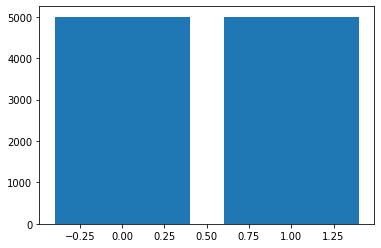

In [117]:
plt.bar(plotBar.index,plotBar)

<BarContainer object of 2 artists>

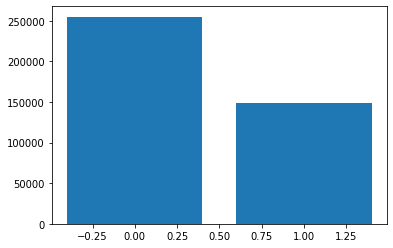

In [78]:
plt.bar(plotBar.index,plotBar)

In [118]:
print('Average word length of questions in question1 is {0:.0f}.'.format(np.mean(train_df['question1'].astype(str).apply(lambda x: len(x.split())))))
print('Average word length of questions in question2 is {0:.0f}.'.format(np.mean(train_df['question2'].astype(str).apply(lambda x: len(x.split())))))

Average word length of questions in question1 is 12.
Average word length of questions in question2 is 12.


In [79]:
print('Average word length of questions in question1 is {0:.0f}.'.format(np.mean(train_df['question1'].astype(str).apply(lambda x: len(x.split())))))
print('Average word length of questions in question2 is {0:.0f}.'.format(np.mean(train_df['question2'].astype(str).apply(lambda x: len(x.split())))))

Average word length of questions in question1 is 11.
Average word length of questions in question2 is 11.


In [119]:
print('Average word length of questions in question1 is {0:.0f}.'.format(np.max(train_df['question1'].astype(str).apply(lambda x: len(x.split())))))
print('Average word length of questions in question2 is {0:.0f}.'.format(np.max(train_df['question2'].astype(str).apply(lambda x: len(x.split())))))

Average word length of questions in question1 is 57.
Average word length of questions in question2 is 57.


In [80]:
print('Average word length of questions in question1 is {0:.0f}.'.format(np.max(train_df['question1'].astype(str).apply(lambda x: len(x.split())))))
print('Average word length of questions in question2 is {0:.0f}.'.format(np.max(train_df['question2'].astype(str).apply(lambda x: len(x.split())))))

Average word length of questions in question1 is 125.
Average word length of questions in question2 is 237.


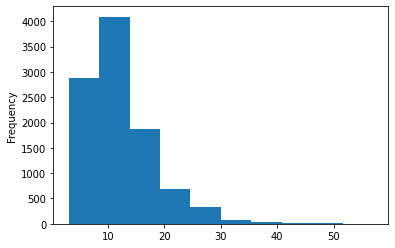

In [120]:
train_df['question1'].astype(str).apply(lambda x: len(x.split())).plot(kind='hist');

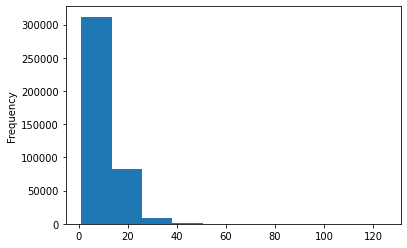

In [81]:
train_df['question1'].astype(str).apply(lambda x: len(x.split())).plot(kind='hist');


In [ ]:
@@@@@@@@@@@@@@@ff
train_df['lenq1'] = train_df['question1'].astype(str).str.len()
train_df['lenq2'] = train_df['question2'].astype(str).str.len()
train_df['lenq1_n'] = train_df['question1_n'].str.len()
train_df['lenq2_n'] = train_df['question2_n'].str.len()

train_df

In [ ]:
@@@@@@@@@@@@@@
plt.plot(train_df['lenq2_n'].value_counts(), train_df['lenq2_n'])
plt.show()
plt.plot(train_df['lenq2_n'],'o')
plt.show()

In [28]:
@@@@@@@@@@@@
train_df['lenq1'].max()

623

In [29]:
@@@@@@@@@@@@@@@
train_df['lenq2'].max()

1169

In [23]:
@@@@@@@@@@@@@@@@@@@@@@@2
for col in [('question1','lenq1'),('question2','lenq1')]:
   # find indices, keep="all" means keep all occurrences. 
   idxs = train_df[col[0]].astype(str).str.len().nlargest(1, keep="all").index
   mean = train_df[col[0]].astype(str).str.len().mean()

   # get values.
   values = train_df.loc[idxs,col[1]]
   values2 = train_df.loc[idxs,col[0]]

   print(values)
   print("mean : ",mean)
   print(len(train_df['question1'][4730]))

35101    623
Name: lenq1, dtype: int64
mean :  59.53671621855599
103
4326      149
153442    131
346481    141
Name: lenq1, dtype: int64
mean :  60.108380123178904
103


In [121]:
# max_seq_length_in_dataset
max_seq_length_in_dataset = max(train_df.question1_n.map(lambda x: len(x)).max(),train_df.question2_n.map(lambda x: len(x)).max())
print("max_seq_length_in_dataset : ",max_seq_length_in_dataset)


max_seq_length_in_dataset :  65


In [84]:
# max_seq_length_in_dataset
max_seq_length_in_dataset = max(train_df.question1_n.map(lambda x: len(x)).max(),train_df.question2_n.map(lambda x: len(x)).max())
print("max_seq_length_in_dataset : ",max_seq_length_in_dataset)


max_seq_length_in_dataset :  244


In [122]:
# mean_seq_length_in_dataset
max_seq_length_in_dataset = max(train_df.question1_n.map(lambda x: len(x)).mean(),train_df.question2_n.map(lambda x: len(x)).mean())
print("mean_seq_length_in_dataset : ",max_seq_length_in_dataset)


mean_seq_length_in_dataset :  12.420184036807361


In [86]:
# mean_seq_length_in_dataset
max_seq_length_in_dataset = max(train_df.question1_n.map(lambda x: len(x)).mean(),train_df.question2_n.map(lambda x: len(x)).mean())
print("mean_seq_length_in_dataset : ",max_seq_length_in_dataset)


mean_seq_length_in_dataset :  11.413188552771526


Take the training data from:
question1   question2   is_duplicate
borrow Repayment Information Borrow Repayment Date 0
become:

question1 question2 is_duplicate question1_n question2_n
Borrow repayment information Borrow repayment date 0 Borrow repayment information Borrow repayment date

After becoming id:
question1 question2 is_duplicate question1_n question2_n
Borrow repayment information Borrow repayment date 0 [31, 639] [31, 255]

In [123]:
# Split training set
X = train_df[['question1_n', 'question2_n']]
Y = train_df['is_duplicate']
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=0.2)

X_train = split_and_zero_padding(X_train, max_seq_length)
X_validation = split_and_zero_padding(X_validation, max_seq_length)

In [124]:
# Convert labels to numbers
Y_train = Y_train.values
Y_validation = Y_validation.values

In [125]:
# Confirm that the data is prepared and correct
print("X_train['left'].shape" , X_train['left'].shape)
print("X_train['right'].shape" , X_train['left'].shape)
print("len(X_train['left'])" , len(X_train['left']))
print("len(Y_train)" , len(Y_train))

assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)

X_train['left'].shape (7998, 32)
X_train['right'].shape (7998, 32)
len(X_train['left']) 7998
len(Y_train) 7998


In [126]:
print(Y_validation)

[0 0 1 ... 0 1 0]


# -----------------base function------------------ #


In [130]:
def shared_model(_input):
    # word vectorization
    embedded = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_shape=(max_seq_length,),
                         trainable=False)(_input)

    # multilayerBi-LSTM
    activations = Bidirectional(LSTM(n_hidden, return_sequences=True), merge_mode='concat')(embedded)
    activations = Bidirectional(LSTM(n_hidden, return_sequences=True), merge_mode='concat')(activations)

    # dropout
    activations = Dropout(0.5)(activations)

    # Attention
    attention = TimeDistributed(Dense(1, activation='tanh'))(activations)
    attention = Flatten()(attention)
    attention = Activation('softmax')(attention)
    attention = RepeatVector(n_hidden * 2)(attention)
    attention = Permute([2, 1])(attention)
    sent_representation = multiply([activations, attention])
    sent_representation = Lambda(lambda xin: K.sum(xin, axis=1))(sent_representation)

    # dropout
    sent_representation = Dropout(0.4)(sent_representation)

    return sent_representation

In [131]:
if __name__ == '__main__':

    # Hyperparameter
    batch_size = 1024
    n_epoch = 15
    n_hidden = 100

    left_input = Input(shape=(max_seq_length,), dtype='float32')
    right_input = Input(shape=(max_seq_length,), dtype='float32')

    left_sen_representation = shared_model(left_input)
    right_sen_representation = shared_model(right_input)

    # The Manhattan distance is introduced, and the original 
    #vector on the obtained transformation concat is 
    #then subjected to a non-linear transformation 
    #through a multi-layer DNN, and the sigmoid obtains the similarity
    
    # I did not use the Mahalanobis distance mentioned 
    #in https://zhuanlan.zhihu.com/p/31638132. 
    #I tried Manhattan distance, point product and cos, 
    #and Manhattan is the best.
    
    man_distance = ManDist()([left_sen_representation, right_sen_representation])
    sen_representation = concatenate([left_sen_representation, right_sen_representation, man_distance])
    similarity = Dense(1, activation='sigmoid')(Dense(2)(Dense(4)(Dense(16)(sen_representation))))
    model = Model(inputs=[left_input, right_input], outputs=[similarity])

    model.compile(loss='mean_squared_error', optimizer= Adam(), metrics=['accuracy'])
    model.summary()

    training_start_time = time()
    malstm_trained = model.fit([X_train['left'], X_train['right']], Y_train,
                               batch_size=batch_size, epochs=n_epoch,
                               validation_data=([X_validation['left'], X_validation['right']], Y_validation))
    training_end_time = time()
    print("Training time finished.\n%d epochs in %12.2f" % (n_epoch, training_end_time - training_start_time))

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 32, 300)      3516600     ['input_5[0][0]']                
                                                                                                  
 embedding_5 (Embedding)        (None, 32, 300)      3516600     ['input_6[0][0]']                
                                                                                            

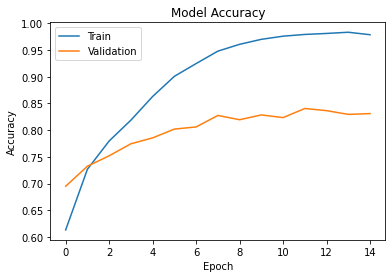

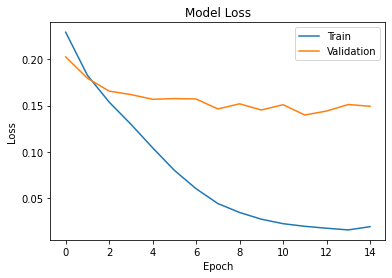

In [132]:
# Plot accuracy

import matplotlib.pyplot as plt
#plt.subplot(211)
plt.plot(malstm_trained.history['accuracy'])
plt.plot(malstm_trained.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
#plt.subplot(212)
plt.plot(malstm_trained.history['loss'])
plt.plot(malstm_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()